# Polaris

In [2]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -1.796e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.668e+01 [aplpy.core]


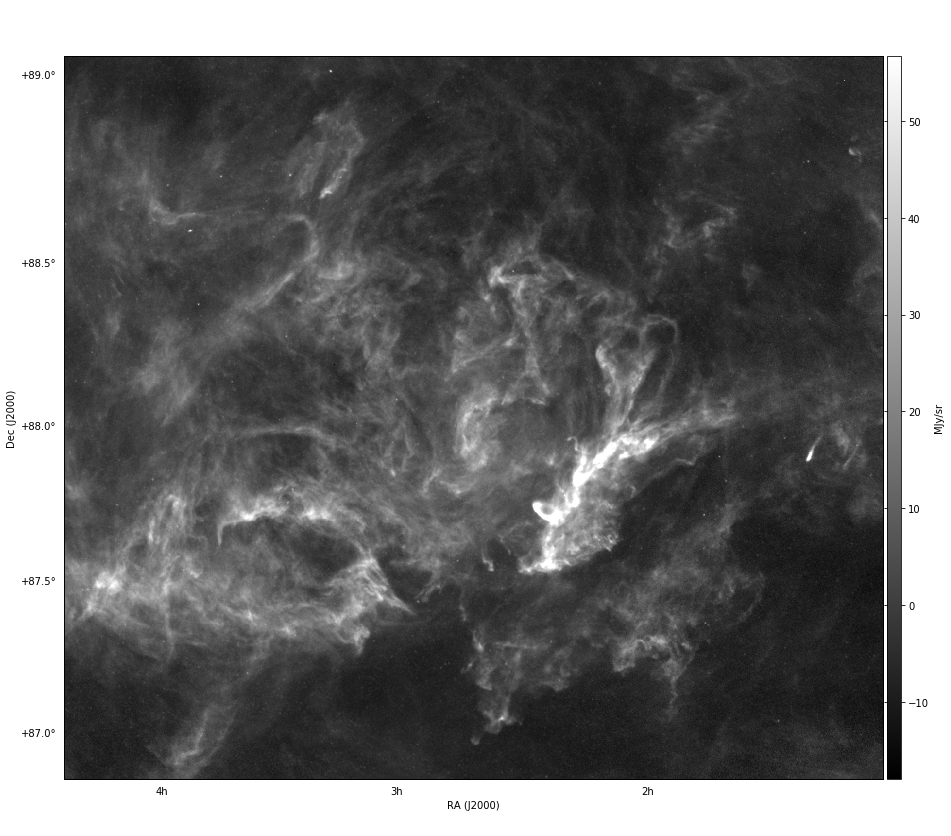

In [4]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/polaris-250_cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.colorbar.set_axis_label_text(r'MJy/sr')

In [5]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [22]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [31]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

#Gain factor from Miville-Deschenes et al. 2010
imn = im*3.3 + 20.1

#Convertion to Jy
#imn= imn * 1.0e6

na = im.shape[1]
nb = im.shape[0]
imzm = imn - np.mean(imn)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1800,1800)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1800,1800,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]
BS1an[0:4] = 1.

dFscl = 150.*np.tan((1./(60.*tab_k))*(np.pi/180.))

Noise = S1a[0,22]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [pc]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(0.01, 10), \
           y_range=(1, 10**8), tools=Tools)
#f.line(dFscl[0:391], spec_k[0:391]/spec_beamn[0:391], legend='Fourier')
#f.line(tab_k, (spec_k-Noise)/spec_beamn, legend='Fourier')
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.5]*27
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, apodize= 0.98, arrdim = np.array([1800,1800]))

#dWscl = 150.*np.tan((1./(60.*wav_k))*(np.pi/180.))

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

#f.diamond(dWscl[0:21], S1an[0,0:21], legend='Wavelet',color='black',line_width=5)
#f.triangle(dWscl[0:21], S1an[1,0:21], legend='Coherent',color='blue',line_width=5)
#f.square(dWscl[0:21], S1an[2,0:21], legend='Gaussian',color='red',line_width=5)
f.diamond(wav_k, (S1a[0,:]-Noise)/BS1an[:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, (S1a[1,:])/BS1an[:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, (S1a[2,:]-Noise)/BS1an[:], legend='Gaussian',color='red',line_width=5)

#Power law fit
#coef,cov = np.polyfit(np.log(dWscl[6:15]),np.log(S1an[2,6:15]),deg=1,cov=True)
#yfit = np.exp(coef[1])*dWscl**coef[0]
coef,cov = np.polyfit(np.log(wav_k),np.log(S1an[2,:]),deg=1,cov=True)
yfit = np.exp(coef[1])*wav_k**coef[0]

#coef2,cov2 = np.polyfit(np.log(dWscl[12:17]),np.log(S1an[1,12:17]),deg=1,cov=True)
#yfit2 = np.exp(coef2[1])*dWscl**coef2[0]
coef2,cov2 = np.polyfit(np.log(wav_k),np.log(S1an[1,:]),deg=1,cov=True)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))
print "Power law coherent = ", coef2[0], np.sqrt(np.diag(cov2))

#f.line(dWscl, yfit, legend='Fit', line_dash='dashed')
#f.line(dWscl, yfit2, line_dash='dashed')
f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

f.legend.location = "top_left"

showbok(f)

[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
Power law Gaussian =  -1.561369218864793 [0.33170946 0.89213434]
Power law coherent =  nan [nan nan]


/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: divide by zero encountered in log


In [32]:
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_Bwav_k.npy',Bwav_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_BS1a.npy',BS1a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_wt.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_S11a.npy',S11a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_wav_k.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_S1a.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_q.npy',q)

In [3]:
Bwav_k=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_Bwav_k.npy')
BS1a=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_BS1a.npy')
wt=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_wt.npy')
S11a=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_S11a.npy')
wav_k=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_wav_k.npy')
S1a=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_S1a.npy')
q=np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_q.npy')

INFO: Auto-setting vmin to -2.329e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.899e+01 [aplpy.core]
INFO: Auto-setting vmin to -2.815e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.208e+01 [aplpy.core]


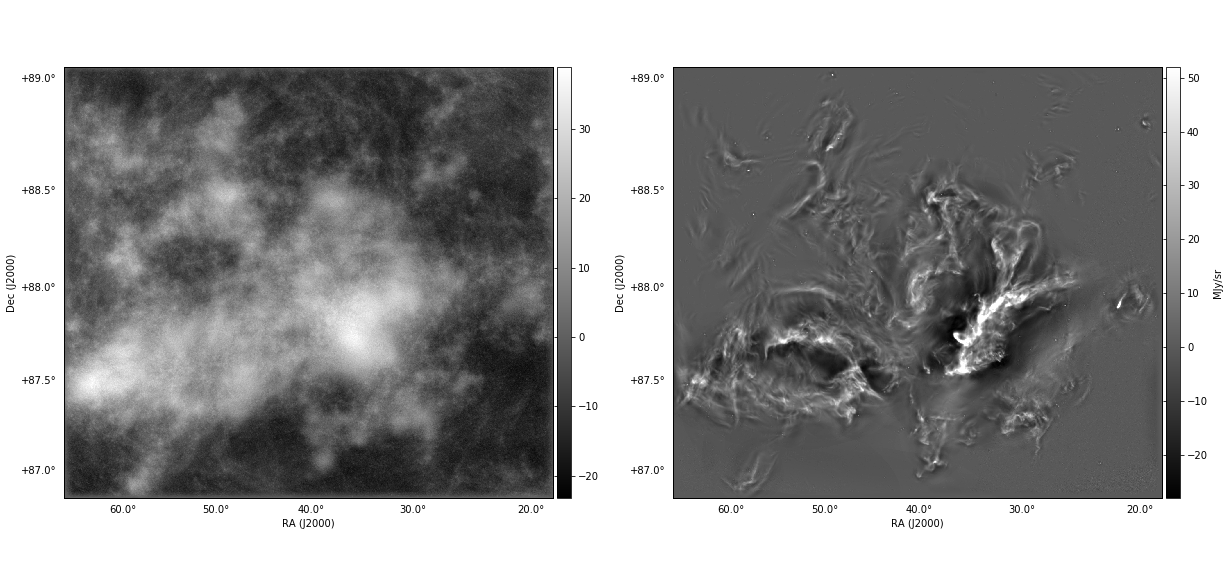

In [51]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.colorbar.set_axis_label_text(r'MJy/sr')

[0.92732202 1.23226176 1.63747761]


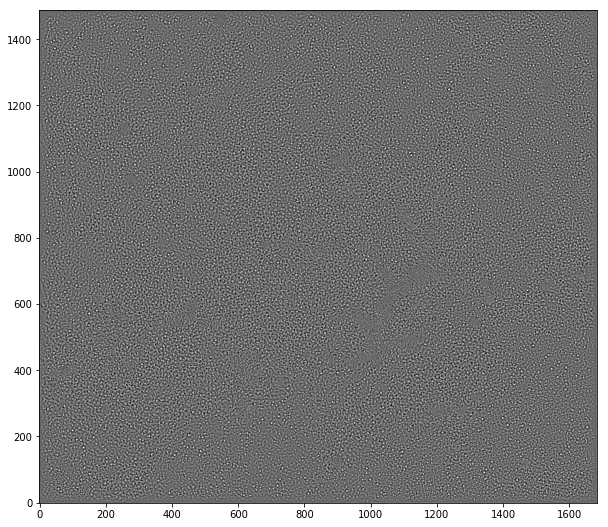

In [8]:
M = wav_k.shape[0]
Noise = np.sum(wt[2*M+18:2*M+21,:,:],axis=0)

figure(figsize(10,10))
imshow(Noise.real,origin='bottom',cmap='gray')
print wav_k[18:21]

[2.5, 2.5, 2.5, 2.5, 2.5, 2.0999999999999996, 2.0999999999999996, 1.9999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.0999999999999996, 2.1999999999999997, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.3, 2.3, 2.4, 2.5, 2.5, 2.5, 2.5, 2.5]
wav_k.shape[0]= 26


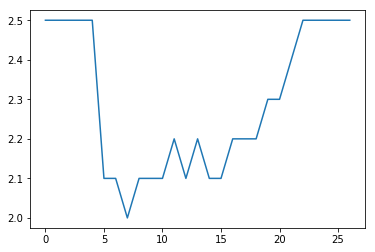

In [27]:
print q
print 'wav_k.shape[0]=',wav_k.shape[0]

x = range(27)
plot(x,np.array(q).reshape(27))

In [57]:
#Plot Beam power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_beamn, legend='Fourier')
f.diamond(Bwav_k, BS1an, legend='Wavelet',color='black',line_width=5)
showbok(f)

## Test on PDFs

(1.5, 2.5)

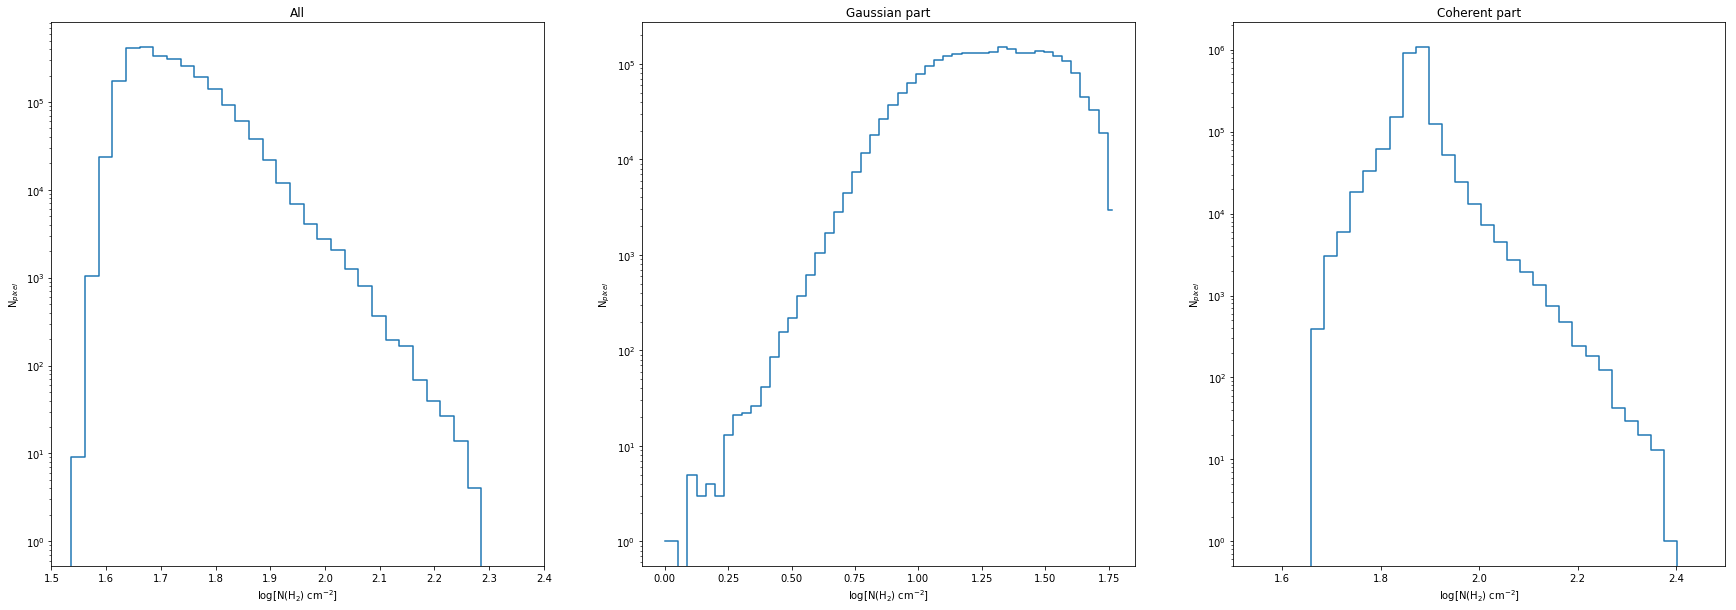

In [75]:
histo, edges = np.histogram(np.log10(im-np.min(im)+1),bins=100)
histoG, edgesG = np.histogram(np.log10(Gaussian.real-np.min(Gaussian.real)+1),bins=50)
histoC, edgesC = np.histogram(np.log10(coherent.real-np.min(coherent.real)+1),bins=100)

plt.figure(1, figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(edges[:-1], histo, drawstyle='steps-mid')
plt.yscale('log')
plt.ylabel(r'N$_{pixel}$')
plt.xlabel(r'log[N(H$_2$) cm$^{-2}$]')
plt.title('All')
plt.xlim([1.5,2.4])

plt.subplot(1,3,2)
plt.plot(edgesG[:-1], histoG, drawstyle='steps-mid')
plt.yscale('log')
plt.ylabel(r'N$_{pixel}$')
plt.xlabel(r'log[N(H$_2$) cm$^{-2}$]')
plt.title('Gaussian part')

plt.subplot(1,3,3)
plt.plot(edgesC[:-1], histoC, drawstyle='steps-mid')
plt.yscale('log')
plt.ylabel(r'N$_{pixel}$')
plt.xlabel(r'log[N(H$_2$) cm$^{-2}$]')
plt.title('Coherent part')
plt.xlim([1.5,2.5])

## Characteristic scale

Looking at the spatial scale where the coherent features appear in the wavelet power spectrum.

In [78]:
#The peak is located at index 7
print "Coherent features appear:", dWscl[7], "pc" 

Coherent features appear: 1.0734716895349021 pc


Text(0.5,1,u'All scales')

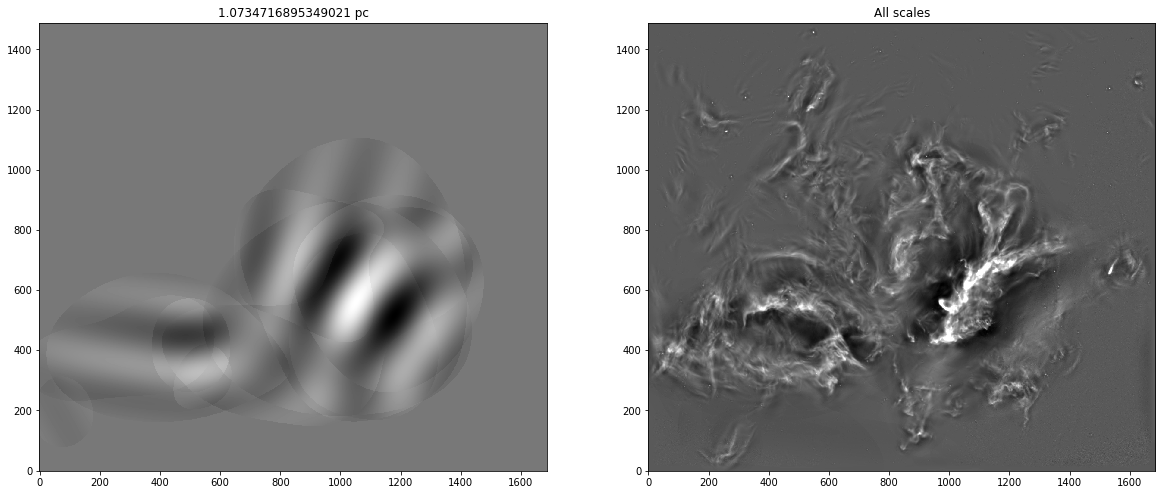

In [87]:
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(wt[M+7,:,:].real,origin='below',cmap='gray')
plt.title(np.str(dWscl[7])+" pc")

plt.subplot(1,2,2)
imshow(np.sum(wt[M:2*M,:,:].real,axis=0),origin='below',cmap='gray', vmin=-28, vmax=52)
plt.title('All scales')

This scale corresponds mainly to the four largest structures which encompass many substructures/filaments.
Let's compare the isotropic wavelet transform of the field at that scale without any segmentation with the Gaussian part.

Text(0.5,1,u'Gaussian part at 1.0734716895349021 pc')

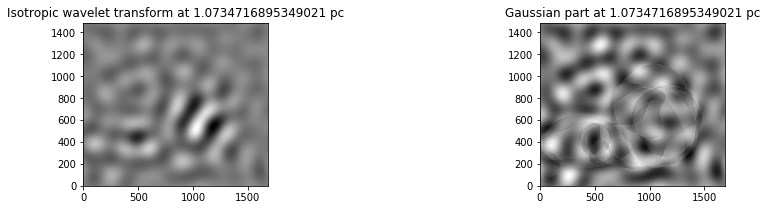

In [93]:
figure(figsize=(15,3))
plt.subplot(1,2,1)
imshow(wt[7,:,:].real,origin='below',cmap='gray')
plt.title("Isotropic wavelet transform at "+np.str(dWscl[7])+" pc")

plt.subplot(1,2,2)
imshow(wt[2*M+7,:,:].real,origin='below',cmap='gray')
plt.title("Gaussian part at "+np.str(dWscl[7])+" pc")

The algorithm successfully extract the most intense features. The "Gaussian part" looks more homogeneous. I plot smaller figures on purpose, so that it is easier for the eye to see the global structures.

Now, let's have a look at the structures at $\sim 0.1$ pc, so index 15 in the power spectrum.

Text(0.5,1,u'Gaussian part at 0.11040889790873945 pc')

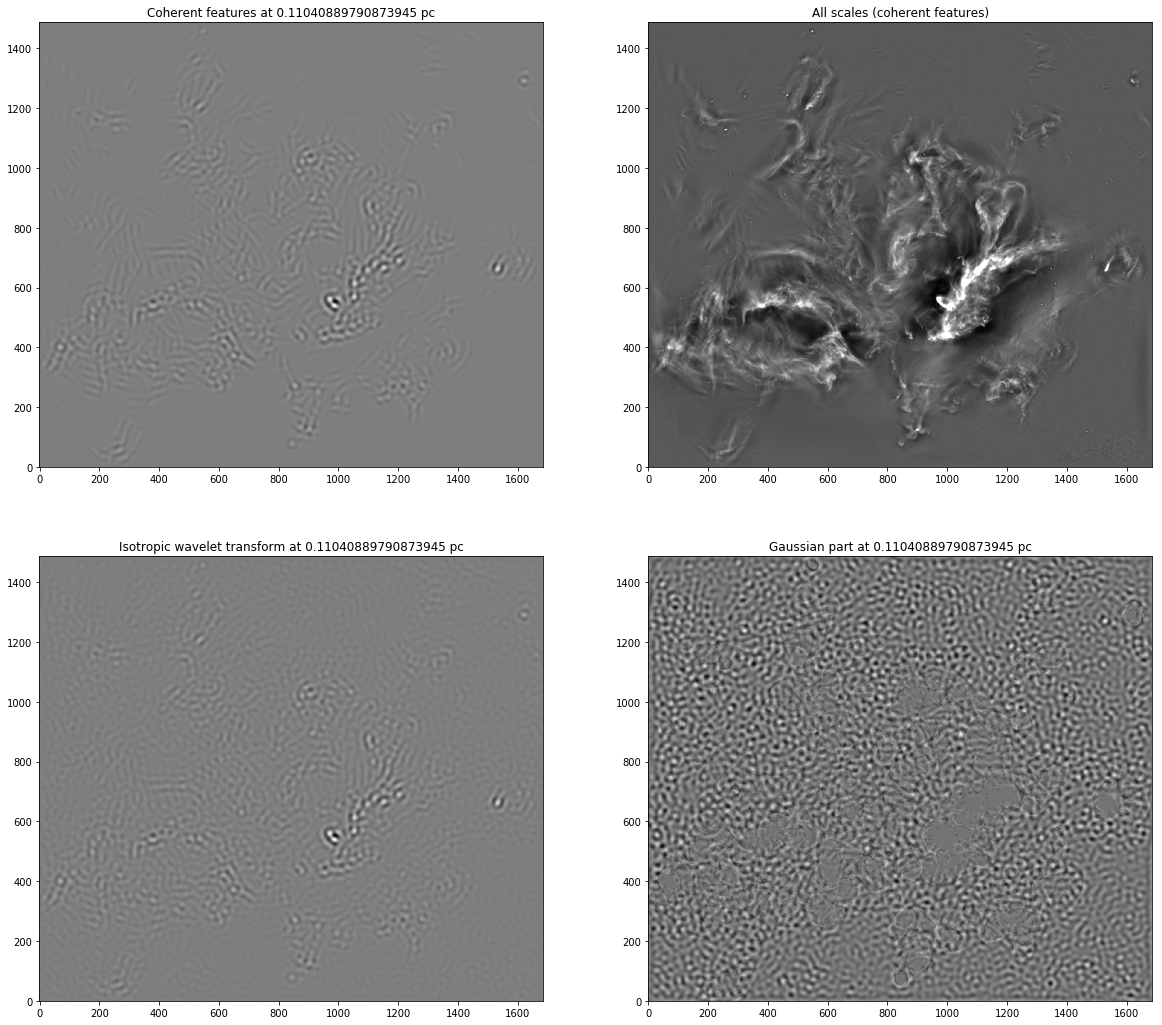

In [98]:
figure(figsize=(20,18))
plt.subplot(2,2,1)
imshow(wt[M+15,:,:].real,origin='below',cmap='gray')
plt.title("Coherent features at "+np.str(dWscl[15])+" pc")

plt.subplot(2,2,2)
imshow(np.sum(wt[M:2*M,:,:].real,axis=0),origin='below',cmap='gray', vmin=-28, vmax=52)
plt.title('All scales (coherent features)')

plt.subplot(2,2,3)
imshow(wt[15,:,:].real,origin='below',cmap='gray')
plt.title("Isotropic wavelet transform at "+np.str(dWscl[15])+" pc")

plt.subplot(2,2,4)
imshow(wt[2*M+15,:,:].real,origin='below',cmap='gray')
plt.title("Gaussian part at "+np.str(dWscl[15])+" pc")

At a scale of $\sim 0.01$ pc we trace mainly the small features where some are definitely filaments.

We have to keep in mind that these images show the sum of all orientations for the Morlet wavelet transform. This is why the coherent structures do not fit entirely with the "holes" in the Gaussian part. Especially if the coherent feature corresponds to a filament mainly sampled in one direction.